# Barrel distortion test
Calculate the barrel distortion as a function of pixel # along the length of the sensor

Insert four phase shifted images in second cell

In [1]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
%matplotlib inline

In [171]:
im_0 = imageio.imread('images/distortion_test_phase0_highfreq.png', as_gray=True)
im_90 = imageio.imread('images/distortion_test_phase90_highfreq.png', as_gray=True)
im_180 = imageio.imread('images/distortion_test_phase180_highfreq.png', as_gray=True)
im_270 = imageio.imread('images/distortion_test_phase270_highfreq.png', as_gray=True)

In [172]:
def get_mid_row(image):
    return image[image.shape[0]//2]

In [173]:
phase = np.arctan((get_mid_row(im_0) - get_mid_row(im_180)) / (get_mid_row(im_270) - get_mid_row(im_90)))

<ipython-input-173-63bc1dd7f450>:1: RuntimeWarning: divide by zero encountered in true_divide
  phase = np.arctan((get_mid_row(im_0) - get_mid_row(im_180)) / (get_mid_row(im_270) - get_mid_row(im_90)))


In [174]:
def plot_freqs(phases, step_size, fit_size, shift):
    i = fit_size
    slopes = []
    offsets = []
    x_values = []
    center_slope = 0
    center_offset = 0
    plt.figure(dpi=200)
    plt.plot(phase, "b.")
    center = phases.shape[0] // 2
    num_steps = (((center + shift) // step_size) * step_size) + fit_size
    while i < len(phases):
        x_values.append(i)
        center = phases[i]
        surround_pts = phases[(i-fit_size):(i+fit_size)]
        x_data = np.arange(0, phases.shape[0])
        x_points = x_data[(i-fit_size):(i+fit_size)]
        coeffs = np.polyfit(x_points, surround_pts, 1)
        slope = coeffs[0]
        offset = coeffs[1]
        line = slope*x_points + offset
        if i == num_steps:
            center_slope = slope
            center_offset = offset
        plt.plot(x_points, line, 'r-' if i != num_steps else 'g-')
        slopes.append(slope)
        offsets.append(offset)
        i += step_size
    plt.show()
    return slopes, offsets, x_values, center_slope, center_offset

In [175]:
def median_filter(row, k=3):
    if k % 2 == 0:
        k += 1
    return sig.medfilt(row, k)

In [176]:
def find_center_slope(phase_arr, i_arr, center_width, fit_size):
    center_location = phase_arr.shape[0] // 2
    abs_phases = np.abs(phase_arr)
    center_indices = i_arr[center_location - center_width: center_location + center_width]
    center_values = abs_phases[center_location - center_width: center_location + center_width] 
    min_index = np.argmin(center_values)
    min_index = center_location - center_width + min_index
    surround_pts = phase_arr[(min_index-fit_size):(min_index+fit_size)]
    x_data = np.arange(0, phase_arr.shape[0])
    x_points = x_data[(min_index-fit_size):(min_index+fit_size)]
    coeffs = np.polyfit(x_points, surround_pts, 1)
    slope = coeffs[0]
    offset = coeffs[1]
    line = slope*x_points + offset
    slope = coeffs[0]
    offset = coeffs[1]
    plt.figure(dpi=150)
    plt.plot(phase_arr, "b.")
    plt.plot(x_points, line, 'r')
    plt.show()
    return slope, offset

In [177]:
def expected_phases(slope, offset, cutoff_diff, k):
    x_data = np.arange(0, phase.shape[0])
    center_slope = slope
    center_offset = offset
    phases = center_slope*x_data + center_offset
    phases = np.arctan(np.tan(phases))
    plt.figure(dpi=150)
    plt.plot(phase, 'b.')
    plt.plot(phases, 'r.')
    plt.show()
    plt.figure(dpi=150)
    plt.ylim(-200, 200)
    plt.axhline(-20, c='k', ls='--')
    plt.axhline(20, c='k', ls='--')
    phase_diff = phases - phase
    full_len = len(phase_diff)
    phase_diff = phase_diff[np.where(np.abs(phase_diff) < cutoff_diff)]
    distortion = phase_diff / center_slope
    x = np.arange(len(distortion))
    new_x = np.linspace( 0., len(distortion), full_len)
    distortion = np.interp(new_x, x, distortion)
    if k == 1:
        err_slope, err_offset = np.polyfit(x_data, distortion, k)
        fit = x_data*err_slope + err_offset
    elif k == 3:
        a, b, c, d = np.polyfit(x_data, distortion, k)
        fit = a*x_data**3 + b*x_data**2 + c*x_data + d
    plt.plot(distortion, 'b.')
    plt.plot(fit, 'r', lw=.8)
    plt.show()

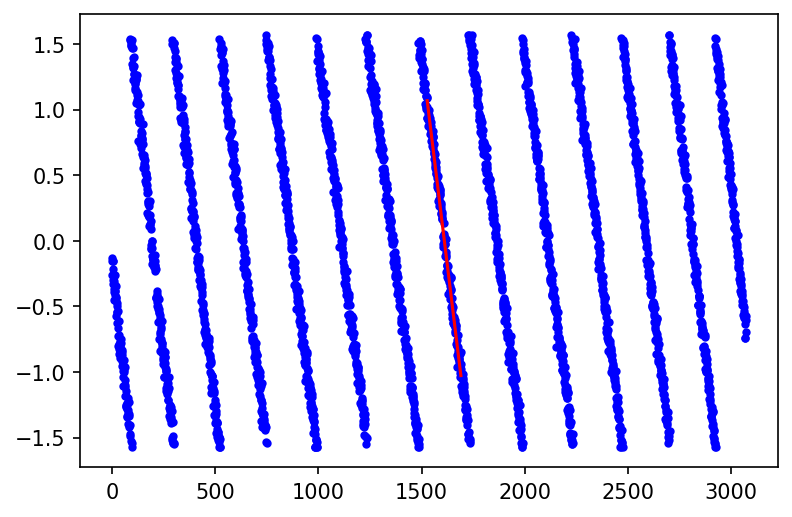

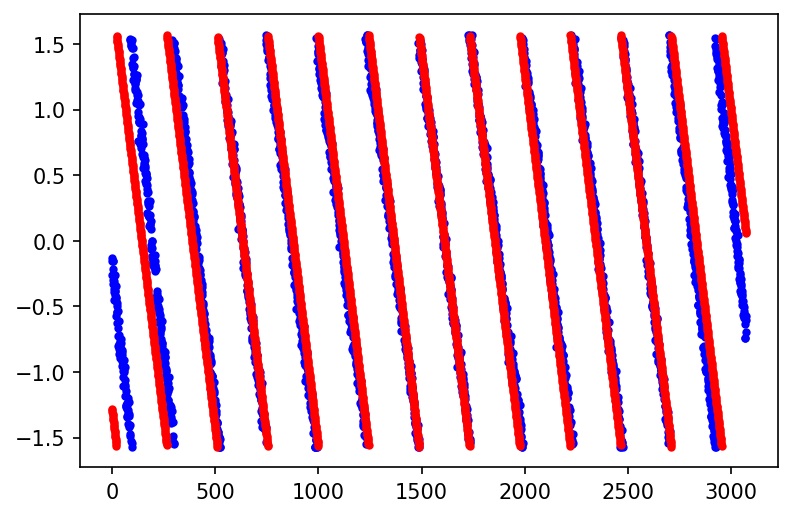

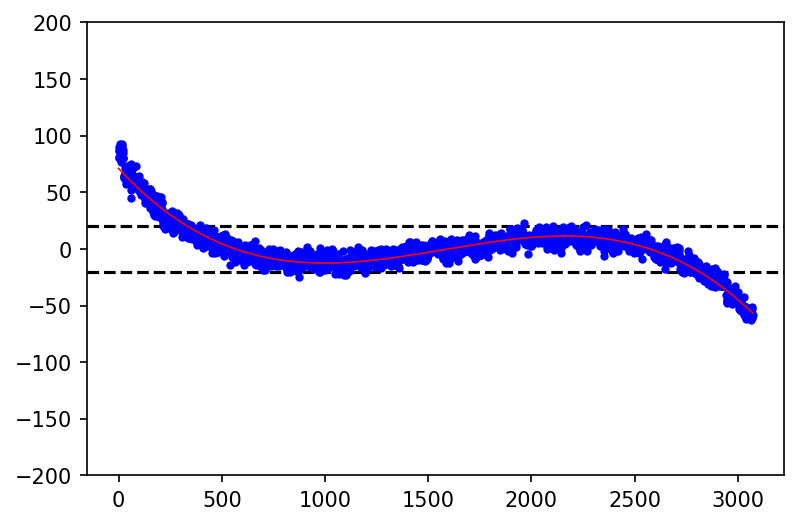

In [179]:
index_arr = np.arange(0, phase.shape[0])
slope, offset = find_center_slope(phase, index_arr, 75, 82)    
expected_phases(slope, offset, 1.9, 3)